In [1]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# MedMNIST import
import medmnist
from medmnist import INFO
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- MedMNIST Data setup ---
data_flag = 'retinamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', download=True)
numSamples = len(train_dataset)                          

Using device: cuda
Using downloaded and verified file: C:\Users\alexr\.medmnist\retinamnist.npz


In [2]:
# Prepare data tensors --------------------------------------------------------
def _get_tensor(ds, n):
    """Stack first n samples, convert to float32 in [0,1]."""
    imgs = []
    for i in range(n):
        x, _ = ds[i]
        if isinstance(x, torch.Tensor):
            t = x.float() / 255.0
        elif isinstance(x, np.ndarray):
            t = torch.from_numpy(x).float() / 255.0
            if t.ndim == 3:
                t = t.permute(2, 0, 1)
        else:
            t = TF.to_tensor(x)
        imgs.append(t[0])
    return torch.stack(imgs).to(device)

# Prepare dataset
X_raw = _get_tensor(train_dataset, numSamples) 
dim = X_raw[0].numel()  # 28*28 = 784
r = 25  # bottleneck / testing rank

# X Stuff
X = X_raw.view(numSamples, -1).T
gammaX = (1/numSamples) * X @ X.T + 1e-5 * torch.eye(dim, device=device)
L_X = torch.linalg.cholesky(gammaX)

# F Stuff
blurKernelSizeF = 5
blurSigmaF = 1.0
forwardBlur = GaussianBlur(kernel_size=blurKernelSizeF, sigma=blurSigmaF)
basisImages = torch.eye(dim).reshape(dim, 1, 28, 28)
F_cols = []
for j in range(dim):
    F_cols.append(forwardBlur(basisImages[j]).flatten())
F = torch.stack(F_cols, dim=1).to(device)
FX = F @ X

# E Stuff
noiseSigma = 0.05
E = torch.randn_like(FX) * noiseSigma
gammaE = noiseSigma**2 * torch.eye(dim, device=device)

# Y Stuff
Y = FX + E
gammaY = F @ gammaX @ F.T + gammaE + 1e-5 * torch.eye(dim, device=device)
L_Y = torch.linalg.cholesky(gammaY)

# Theoretical Optimizer
C = gammaX @ F.T @ torch.linalg.inv(L_Y.T)
U, S, Vh = torch.linalg.svd(C)
U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
C_r = U_r @ S_r @ Vh_r
M_r = C_r @ torch.linalg.inv(L_Y)

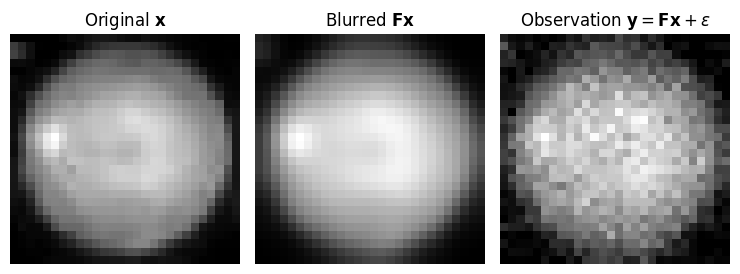

In [3]:
# ── quick 1×3 preview: (\bar{X}, F \bar{X}, F \bar{X} + E) ─────────────────────
import os
import matplotlib.pyplot as plt

# random training-set index
#idx = np.random.randint(0, numSamples)
idx = 100

# (i) original image  →  (H,W)
orig_img = X_raw[idx].cpu()          # already in [0,1]
if orig_img.ndim == 3:               # safety: drop channel dim
    orig_img = orig_img[0]

# (ii) blurred image  F \bar{X}
blur_img = forwardBlur(orig_img.unsqueeze(0)).squeeze(0).cpu()

# (iii) blurred + noise image  F \bar{X} + E
noise            = torch.randn_like(blur_img) * noiseSigma
blur_noise_img   = (blur_img + noise).clamp(0, 1).cpu()

# ── plot & save ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.7))
axes[0].imshow(orig_img,        cmap='gray')
axes[0].set_title(r'Original $\mathbf{x}$')
axes[0].axis('off')

axes[1].imshow(blur_img,        cmap='gray')
axes[1].set_title(r'Blurred $\mathbf{F} \mathbf{x}$')
axes[1].axis('off')

axes[2].imshow(blur_noise_img,  cmap='gray')
axes[2].set_title(r'Observation $\mathbf{y} = \mathbf{F} \mathbf{x} + \varepsilon$')
axes[2].axis('off')

plt.tight_layout()

out_dir = f"end2endpics/MedMNIST"
os.makedirs(out_dir, exist_ok=True)
#plt.savefig(f"{out_dir}/{data_flag}_mapping{idx}_{r}.png", dpi=300)
plt.show()


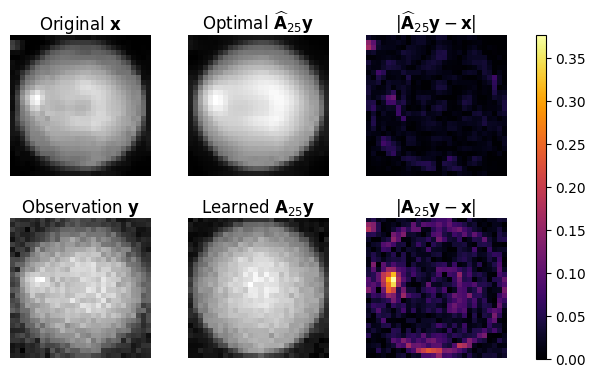

In [4]:
# Autoencoder setup 
batch_size = 128
num_epochs = 200

X_tensor = X.clone().to(torch.float32)
Y_tensor = Y.clone().to(torch.float32)

class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=False)
    def forward(self, x):
        return self.decoder(self.encoder(x))

model     = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop using average per-sample L2 error 
train_errors = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    outputs = model(Y.T)
    target  = X.T

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    # Evaluate and store error after each epoch
    with torch.no_grad():
        A_learned = model.decoder.weight @ model.encoder.weight

        diffs = A_learned @ Y - X
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()  # average per-sample l2 discrepancy

        train_errors.append(avg_l2_err)


# Compact 2×3 gallery with Everforest colormap 
from matplotlib import gridspec


idx = 100

orig_img   = X_raw[idx].view(28, 28).cpu()
y_img      = Y[:, idx].view(28, 28).cpu()
opt_img    = (M_r @ Y)[:, idx].view(28, 28).cpu()
learn_img  = (A_learned @ Y)[:, idx].view(28, 28).cpu()

err_opt   = torch.abs(opt_img   - orig_img)
err_learn = torch.abs(learn_img - orig_img)
err_vmin, err_vmax = 0.0, max(err_opt.max(), err_learn.max()).item()

fig = plt.figure(figsize=(7, 4.2))
gs  = gridspec.GridSpec(
    2, 4,
    width_ratios=[1, 1, 1, 0.06],
    wspace=0.20, hspace=0.30
)

# row 0
ax = fig.add_subplot(gs[0, 0])
ax.imshow(orig_img, cmap='gray')
ax.set_title(r'Original $\mathbf{x}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 1])
ax.imshow(opt_img, cmap='gray')
ax.set_title(fr'Optimal $\widehat{{\mathbf{{A}}}}_{{{r}}} \mathbf{{y}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(err_opt, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\widehat{{\mathbf{{A}}}}_{{{r}}} \mathbf{{y}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# row 1
ax = fig.add_subplot(gs[1, 0])
ax.imshow(y_img, cmap='gray')
ax.set_title(r'Observation $\mathbf{y}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 1])
ax.imshow(learn_img, cmap='gray')
ax.set_title(fr'Learned $\mathbf{{A}}_{{{r}}} \mathbf{{y}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 2])
ax.imshow(err_learn, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\mathbf{{A}}_{{{r}}} \mathbf{{y}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# color-bar
cax = fig.add_subplot(gs[:, 3])
plt.colorbar(im, cax=cax)
cax.yaxis.tick_right()
plt.show()

In [5]:
import os, pickle, torch
from collections import defaultdict
from copy import deepcopy
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt

# pastel-Everforest colours
ef_pastel   = ['#a7c080', '#d3869b', "#83c0c0", '#e69875', '#a988b0', "#b8912f"]
line_styles = {'theory': '-',  'learned': '--'}
markers     = {'theory': 'o',  'learned': 's'}
lw, ms      = 1.5, 4

# where to stash matrices and final plots 
save_root     = "E2EInvPics"
matrices_root = os.path.join(save_root, "MedMNIST", "Matrices")
tests_root    = os.path.join(save_root, "MedMNIST", "Tests")
os.makedirs(matrices_root, exist_ok=True)
os.makedirs(tests_root, exist_ok=True)

# helper: run rank sweep on ONE MedMNIST subset 
def run_rank_sweep(data_flag, ranks, train_epochs=350, lr=1e-3):
    """Return ([theory avg l2], [AE avg l2]) for the given dataset
       and store matrices to pickles for every rank."""
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])
    train_ds = DataClass(split='train', download=True)

    numSamples = int(0.8 * len(train_ds))
    X_raw = _get_tensor(train_ds, numSamples)
    dim = X_raw[0].numel()

    X = X_raw.view(numSamples, -1).T
    gammaX = (1 / numSamples) * X @ X.T + 1e-5 * torch.eye(dim, device=device)
    L_X = torch.linalg.cholesky(gammaX)

    blurKernelSizeF = 5
    blurSigmaF = 1.0
    blur = GaussianBlur(kernel_size=blurKernelSizeF, sigma=blurSigmaF)
    basisImages = torch.eye(dim).reshape(dim, 1, 28, 28)
    F_cols = [blur(basisImages[j]).flatten() for j in range(dim)]
    F = torch.stack(F_cols, dim=1).to(device)

    FX = F @ X
    noiseSigma = 0.05
    E = torch.randn_like(FX) * noiseSigma
    Y = FX + E

    gammaE = noiseSigma**2 * torch.eye(dim, device=device)
    gammaY = F @ gammaX @ F.T + gammaE + 1e-5 * torch.eye(dim, device=device)
    L_Y = torch.linalg.cholesky(gammaY)

    theory_err, learned_err = [], []
    ds_dir = os.path.join(matrices_root, data_flag)
    os.makedirs(ds_dir, exist_ok=True)

    for r in ranks:
        if r % 100 == 0:
            print(f"On Rank {r}")

        C = gammaX @ F.T @ torch.linalg.inv(L_Y.T)
        U, S, Vh = torch.linalg.svd(C)
        U_r = U[:, :r]
        S_r = torch.diag(S[:r])
        Vh_r = Vh[:r, :]
        C_r = U_r @ S_r @ Vh_r
        M_r = C_r @ torch.linalg.inv(L_Y)

        diffs_opt = M_r @ Y - X
        avg_l2_opt = torch.norm(diffs_opt, dim=0).mean().item()
        theory_err.append(avg_l2_opt)

        ae = LinearAutoencoder(dim, r).to(device)
        opt = optim.Adam(ae.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for _ in range(train_epochs):
            opt.zero_grad()
            out = ae(Y.T)
            loss = criterion(out, X.T)
            loss.backward()
            opt.step()

        with torch.no_grad():
            W_enc = ae.encoder.weight.detach().cpu()
            W_dec = ae.decoder.weight.detach().cpu()
            A = W_dec @ W_enc
            diffs_learn = A.to(device) @ Y - X
            avg_l2_learn = torch.norm(diffs_learn, dim=0).mean().item()
        learned_err.append(avg_l2_learn)

        dump_path = os.path.join(ds_dir, f"rank_{r:03d}.pkl")
        with open(dump_path, "wb") as f:
            pickle.dump(
                {
                    "optimalMatrix": M_r.cpu(),
                    "encoderWeight": W_enc,
                    "decoderWeight": W_dec,
                },
                f,
                protocol=pickle.HIGHEST_PROTOCOL,
            )

    return theory_err, learned_err

# run all requested datasets (original sizes of: 200k, 100k, 50k, 10k, 1k)
datasets  = ['tissuemnist', 'chestmnist', 'organamnist', 'retinamnist']
ranks     = list(range(25, 776, 25))
results   = defaultdict(dict)
num_epochs = 200 # define here for training / plot naming

for flag in datasets:
    print(f"\n▶ Running rank sweep for {flag} …")
    th, le = run_rank_sweep(flag, ranks, train_epochs=num_epochs)
    results[flag]['theory']  = th
    results[flag]['learned'] = le



▶ Running rank sweep for tissuemnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\tissuemnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for chestmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for organamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\organamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for retinamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\retinamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700


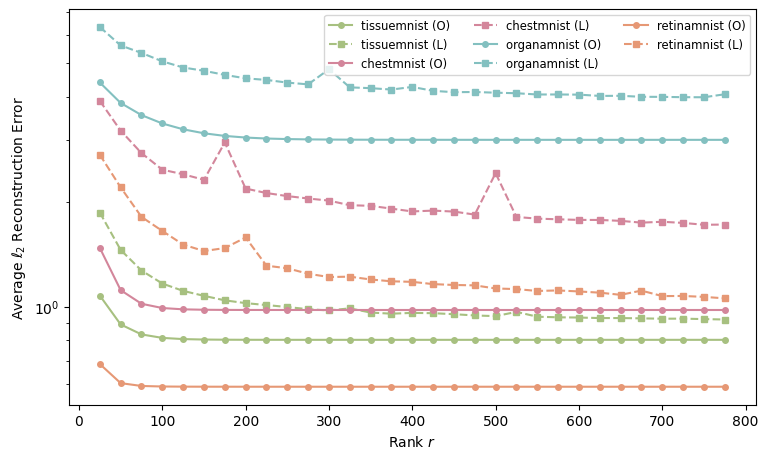

In [6]:
# combined plot
plt.figure(figsize=(7.8, 4.7))
short_label = {'theory': 'O', 'learned': 'L'}

for i, flag in enumerate(datasets):
    col = ef_pastel[i % len(ef_pastel)]
    for kind in ('theory', 'learned'):
        plt.plot(ranks,
                 results[flag][kind],
                 line_styles[kind],
                 marker=markers[kind],
                 color=col,
                 lw=lw,
                 ms=ms, 
                 label=f"{flag} ({short_label[kind]})")

plt.xlabel('Rank $r$')
plt.ylabel(r'Average $\ell_2$ Reconstruction Error')
plt.yscale('log')
#plt.title('Average $\ell_2$ Error vs. Rank')
plt.legend(ncol=3, fontsize='small')
plt.tight_layout()
#plt.savefig("end2endpics/MedMNIST/Tests/medmnist_rank_sweep_avg_2000_epoch.png")
plt.show()

In [7]:
# ── Inspect stored matrices & compare singular values (4 decimals) ─────────
#    • Lists datasets / ranks, loads each pickle
#    • Computes singular values of
#        – Bayes–optimal map  Mr
#        – Learned map        A = W_dec @ W_enc
#    • Prints top-k singular values (rounded to 4 decimals) and relative ℓ2 error

import os, pickle, torch

base_dir  = "E2EInvPics/MedMNIST/Matrices"
top_k     = 10                              # how many singular values to show
torch.set_printoptions(edgeitems=3, linewidth=120, sci_mode=False)

for dataset in sorted(os.listdir(base_dir)):
    ds_dir = os.path.join(base_dir, dataset)
    if not os.path.isdir(ds_dir):
        continue

    print(f"\n══════════  {dataset.upper()}  ══════════")
    for fname in sorted(fn for fn in os.listdir(ds_dir) if fn.endswith(".pkl")):
        rank   = int(fname.split("_")[1].split(".")[0])        # rank_050.pkl → 50
        fpath  = os.path.join(ds_dir, fname)

        # ── load matrices ───────────────────────────────────────────────────
        with open(fpath, "rb") as f:
            mats = pickle.load(f)

        Mr   = mats["optimalMatrix"]
        Wenc = mats["encoderWeight"]
        Wdec = mats["decoderWeight"]
        A    = Wdec @ Wenc                                    # learned full map

        # ── singular values ────────────────────────────────────────────────
        s_opt    = torch.linalg.svdvals(Mr)
        s_learn  = torch.linalg.svdvals(A)

        rel_err = torch.norm(s_opt - s_learn) / torch.norm(s_opt)

        # Round singular values to 4 decimal places for print
        s_opt_rounded   = [round(v.item(), 4) for v in s_opt[:top_k]]
        s_learn_rounded = [round(v.item(), 4) for v in s_learn[:top_k]]

        print(f"\n— Rank {rank:3d} —  ({fpath})")
        #print("optimalMatrix shape :", tuple(Mr.shape))
        #print("encoderWeight shape :", tuple(Wenc.shape))
        #print("decoderWeight shape :", tuple(Wdec.shape))
        print(f"Relative ℓ₂ error on singular values: {rel_err:.3e}")
        print(f"Top {top_k} σ(M_r):", s_opt_rounded)
        print(f"Top {top_k} σ(A)  :", s_learn_rounded)

        # Uncomment next lines if you want FULL singular value lists
        # print("\nAll σ(M_r):\n", s_opt.cpu())
        # print("\nAll σ(A):\n",   s_learn.cpu())



══════════  BREASTMNIST  ══════════

— Rank  25 —  (E2EInvPics/MedMNIST/Matrices\breastmnist\rank_025.pkl)
Relative ℓ₂ error on singular values: 1.589e-01
Top 10 σ(M_r): [2.127, 1.7389, 1.7065, 1.6334, 1.6112, 1.5871, 1.5641, 1.5376, 1.5183, 1.5075]
Top 10 σ(A)  : [2.1078, 2.081, 2.0531, 2.0101, 1.9674, 1.8921, 1.8599, 1.8454, 1.8084, 1.7963]

— Rank  50 —  (E2EInvPics/MedMNIST/Matrices\breastmnist\rank_050.pkl)
Relative ℓ₂ error on singular values: 1.213e-01
Top 10 σ(M_r): [2.127, 1.7389, 1.7065, 1.6334, 1.6112, 1.5871, 1.5641, 1.5376, 1.5183, 1.5075]
Top 10 σ(A)  : [2.3319, 1.9307, 1.9118, 1.8964, 1.8477, 1.8256, 1.8107, 1.7695, 1.7535, 1.7474]

— Rank  75 —  (E2EInvPics/MedMNIST/Matrices\breastmnist\rank_075.pkl)
Relative ℓ₂ error on singular values: 1.461e-01
Top 10 σ(M_r): [2.127, 1.7389, 1.7065, 1.6334, 1.6112, 1.5871, 1.5641, 1.5376, 1.5183, 1.5075]
Top 10 σ(A)  : [2.5129, 1.9984, 1.9344, 1.8858, 1.848, 1.8095, 1.7963, 1.7867, 1.7815, 1.7298]

— Rank 100 —  (E2EInvPics/MedMNIST